# **Lois sécuritaires et criminalité en France**
---

<small>*Par Arthur Bidel, William Olivier et Anh Linh Piketty*</small>

<br>

## Introduction<a class="anchor" id="partie1"></a>

Le thème de l'insécurité, avec celui de l'ordre, occupent une place importante dans le débat public et l'espace politique de ces dernières décennies. Ancrée à droite, la dénonciation d'une justice laxiste accompagne souvent la mise en exergue d'un "sentiment d'insécurité". Ce type de revendication repose sur plusieurs prémisses. Déjà de l'existence des phénomènes dénoncés mais aussi d'un effet à la baisse d'une législation plus stricte sur les phénomènes délinquants. Dans quelle mesure ces postulats s'appuient sur un ancrage empirique concret ? 

Ce projet de programmation s'inscrit dans la continuité de ce débat et tente (modestement) d'identifier l'effet de la production législative sur la criminalité et la délinquance en France. L'objet initial de notre curiosité était de vérifier si un effet à la baisse de la législation sécuritaire sur les taux de criminalité et de délinquance  était en effet constatable. Additionnellement, nous avons cherché à dresser un portrait plus descriptif de l'évolution de ces phénomènes sur les 20 dernières années ainsi que de la législation associée.

Les chiffres répertoriant les nombres de crimes et délit en France sont aujourd'hui disponible sur d'assez large et période et permettent, bien qu'imparfaitement de documenter les différents aspects et évolutions de la criminalité dans l'hexagone. De même, la production législative est rendue disponible au public permettant de constater son évolution quantitativement et qualitativement. Nous approchons les textes de lois sous un angle plutôt quantitatif ici ce qui ne permet pas de mesurer une augmentation de la sévérité des textes par exemple, des approches NLP pourrait être intéressantes à développer pour approfondir cet angle de recherche. 

*NB1 : Les fonctions de visualisation ont été déplacées dans un script python (***visualisation.py***) pour plus de lisibilité*<br>
*NB2 : Le travail de récupération et de mise en forme des données a été assez long pour les deux bases de données (sur les infractions et la législation) et deux autres notebooks leur sont consacrés. Le sommaire cliquable renvoie vers ces notebooks pour chacune des parties correspondantes*

## Sommaire

* [Introduction](#partie1)
* [Installation](#partie2)
* [Récuparation et description des données](#partie3)
    * Base délinquance [(voir le notebook *database_délinquance*)](database_délinquance.ipynb)
    * Base légifrance [(voir le notebook *database_légifrance*)](database_légifrance.ipynb)
* [Analyse exploratoire](#partie4)
    * [Portrait de la délinquance en France](#partie41)
        * [Description et visualisation](#partie411)
        * [Cartographie](#partie412)
    * [La législation sécuritaire en France](#partie42)
        * [Statistiques descriptives](#partie421)
* [Modélisation](#partie5)
    * [Fusion des bases de données](#partie51)
    * [Régression de tel indicateur de criminalité sur la production législative](#partie52)
        * [Simple ?????]()
        * [Panel ?????]()
    * [Décalage temporel ?????]()
* [Conclusion et perspectives](#partie6)

## Installation<a class="anchor" id="partie2"></a>

In [1]:
!pip install -r requirements.txt

In [2]:
# Modules essentiels pour ce script
import requests
import os
import zipfile
import s3fs
import numpy as np
import pandas as pd
import geopandas as gpd

# Fonctions et styles personnalisés importés de visualisation.py
from visualisation import (
    charte_graphique,
    charte_graphique2,
    charte_graphique3,
    dictionnaire_geo,
    tracer_evolution_taux,
    tracer_evolution_taux_relatif_lisse,
    boxplot_indicateur_par_saison,
    evolution_indicateur_animation,
    animer_evolution_densite,
    evolution_idf_animation,
    get_increase,
    tri_occurrence,
    plot_histogram,
    camembert,
    nb_lignes_traitant,
    filter_rows_with_keyword,
    count_crime_keywords,
    évolution_indicateur,
    évolution_indicateur,
)

## Récuparation et description des données<a class="anchor" id="partie3"></a>

Les tableaux de données conçus au début de notre travail, dans les deux notebooks consacrés, ont tous les deux été stockés sur S3 et on les récupère prêts à l'usage dans cette partie. Les parties de récupération et nettoyage des données sont donc optionnelles à la lecture mais offrent néanmoins des éclairages méthodologiques quant à la construction des indicateurs et des variables utilisées dans ce travail (lisez les svp...).

<span style="color:red;">**régler le problème de ce code marche pas**</span>

In [3]:
import s3fs

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

MY_BUCKET = "anhlinh"
fs.ls(MY_BUCKET)

['anhlinh/diffusion']

* #### Tableaux de données concernant la criminalité : 

In [4]:
MY_BUCKET = "anhlinh"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/df_indicateurs_dep.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    df_indicateurs_dep = pd.read_csv(file_in)

# Vérification
df_indicateurs_dep.head()

,Unnamed: 0,Année,Département,Indicateur,Nombre,Population,Taux (/10 000),Nom Département,Superficie (km2),Densité
0,0,1996,01,Homicides,17.0,499310,0.340470,Ain,5762,86.655675
1,1,1996,02,Homicides,14.0,538017,0.260215,Aisne,7362,73.080277
2,2,1996,03,Homicides,11.0,349376,0.314847,Allier,7340,47.598910
3,3,1996,04,Homicides,6.0,137453,0.436513,Alpes-de-Haute-Provence,6925,19.848809
4,4,1996,05,Homicides,5.0,118526,0.421848,Hautes-Alpes,5549,21.359885


In [5]:
MY_BUCKET = "anhlinh"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/df_indicateurs_nat.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    df_indicateurs_nat = pd.read_csv(file_in)

# Vérification
df_indicateurs_nat.head()

,Unnamed: 0,Date,Zone,Indicateur,Nombre,Population,Taux (/10 000),Année,Mois,Saison,Taux relatif,Taux de pauvreté (%)
0,0,1996-01-01,France_Métro,Coups et blessures volontaires,5616.0,57936,0.969345,1996,1,Hiver,1.000000,19.3
1,1,1996-02-01,France_Métro,Coups et blessures volontaires,6115.0,57943,1.055347,1996,2,Hiver,1.088722,19.3
2,2,1996-03-01,France_Métro,Coups et blessures volontaires,6668.0,57951,1.150627,1996,3,Printemps,1.187015,19.3
3,3,1996-04-01,France_Métro,Coups et blessures volontaires,6800.0,57963,1.173162,1996,4,Printemps,1.210262,19.3
4,4,1996-05-01,France_Métro,Coups et blessures volontaires,7415.0,57976,1.278978,1996,5,Printemps,1.319424,19.3


Pour ce qui est de la délinquance, nous disposons de deux tableaux de données, un à l'échelle départementale et un à l'échelle nationale. On trouve dans chacun d'entre eux huit indicateurs de criminalité et de délinquance construit selon la méthodologie actuelle du ministère de l'intérieur. Les huits indicateurs sont les : *homicides*, *tentatives d'homicides*, *coups et blessures volontaires*, *vols avec violence*, *vols sans violence*, *escroqueries*, *violences sexuelles* et *infractions liées à la consommation ou la vente de stupéfiants*.

Nous avons utilisé les nombres brut d'infractions recensées par les forces de l'ordre, par types (107 différents), entre 1996 et 2022, mis à disposition en open data par le ministère de l'intérieur ainsi que les estimations de population de l'INSEE pour obtenir les taux de délinquance (définit comme le rapport du nombre de délit/crime sur la population) associés à chacun des indicateurs.

Nous avons également déjà ajouté à ces bases les variables qui nous serviront de contrôle dans la partie modélisation de ce travail. A savoir la densité pour la base départementale et le taux de pauvreté pour la base nationale. La densité sert ici de proxy à la densité urbaine qui pourrait à la fois être un facteur criminogène et un handicap pour le maintien de l'ordre. Elle a été déterminée grâce aux estimations de population déjà mentionnées et aux superficie des départements scrapées de Wikipédia. Le taux de pauvreté a été obtenue via l'INSEE mais malheureusement nous n'avons pas trouvé de données à l'échelle départementale pour toutes les années couvertes par nos bases.

La plupart de nos sources comportaient des données manquantes pour les territoires d'Outre-Mer et nous avons donc décidé de centrer notre travail sur la France métropolitaine. De même il n'était pas possible d'obtenir des données à granularité mensuelle pour les données départementales et on s'est donc satisfait d'une granularité annuelle. 

Vous pouvez trouvez plus de précision sur la construction de ces tables dans le notebook consacré ([juste là !](database_délinquance.ipynb)).

* #### Tableaux de données concernant la production législative : 

In [6]:
MY_BUCKET = "anhlinh"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/df_loda.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    df_loda = pd.read_csv(file_in)

# Vérification
df_loda.head()

,Unnamed: 0,Titre,ID,Date,Nature,Etat,Origine,Date Publication,Année,Mois
0,0,Arrêté du 31 décembre 2008 relatif aux modalit...,LEGITEXT000020083722_27-05-2024,2008-12-31,ARRETE,VIGUEUR,LEGI,2009-01-01T00:00:00.000+0000,2009,1
1,1,Arrêté du 31 décembre 2008 portant création d'...,LEGITEXT000020167092_30-01-2009,2008-12-31,ARRETE,VIGUEUR,LEGI,2009-01-29T00:00:00.000+0000,2009,1
2,2,Décret n° 2008-1549 du 31 décembre 2008 portan...,LEGITEXT000020080924_02-01-2009,2008-12-31,DECRET,VIGUEUR,LEGI,2009-01-01T00:00:00.000+0000,2009,1
3,3,Arrêté du 31 décembre 2008 relatif aux modalit...,LEGITEXT000020083722_18-12-2015,2008-12-31,ARRETE,VIGUEUR,LEGI,2009-01-01T00:00:00.000+0000,2009,1
4,4,Arrêté du 31 décembre 2008 relatif aux modalit...,LEGITEXT000049943833_01-10-2024,2008-12-31,ARRETE,VIGUEUR,LEGI,2009-01-01T00:00:00.000+0000,2009,1


En ce qui concerne la production législative, notre DataFrame principal recense le nombre de textes publiés chaque mois, classés par type (Lois, Arrêtés, Ordonnances, Décrets et Décisions) de 2006 à 2022. Ces données proviennent du fonds LODA via l'API délivrée par Légifrance. 

Cependant, les données ne sont pas exhaustives (et par conséquent non représentatives de l’ensemble de l’activité législative) puisqu'elles ne reflètent pas les modifications législatives plus subtiles, telles que l’alourdissement des peines, la modification d’articles existants ou l’ajout de précisions juridiques (requalification d’une infraction mineure en délit par exemple) qui peuvent avoir un impact significatif sans pour autant générer de nouveaux textes.

Ces données offrent, néanmoins, un aperçu des thématiques traitées depuis 2006, mettant en évidence la fréquence de publication des textes législatifs. Cette base de données nous donnent accès au nombre d’occurrences de chaque catégorie de texte sans refléter leur portée ou leur impact réel. Par exemple, une loi largement débattue apparaît de la même manière qu’un arrêté technique de moindre envergure.

Cette absence de mesure du degré d’importance ou des modifications souligne les limites de cette étude : l'analyse reste quantitative et des approches en NLP pourrait enrichir la démarche en permettant d'évaluer la sévérité des textes adoptés par exemple. 

De même vous pouvez, pour plus de détails, consulter le notebook consacré ([ici](database_légifrance.ipynb)).

## Analyse exploratoire<a class="anchor" id="partie4"></a>

### Portrait de la délinquance en France<a class="anchor" id="partie41"></a>

#### Description et visualisation<a class="anchor" id="partie411"></a>

Etudions d'abord l'évolution de chacun de nos indicateurs sur la période de données disponible (1996 à 2022).

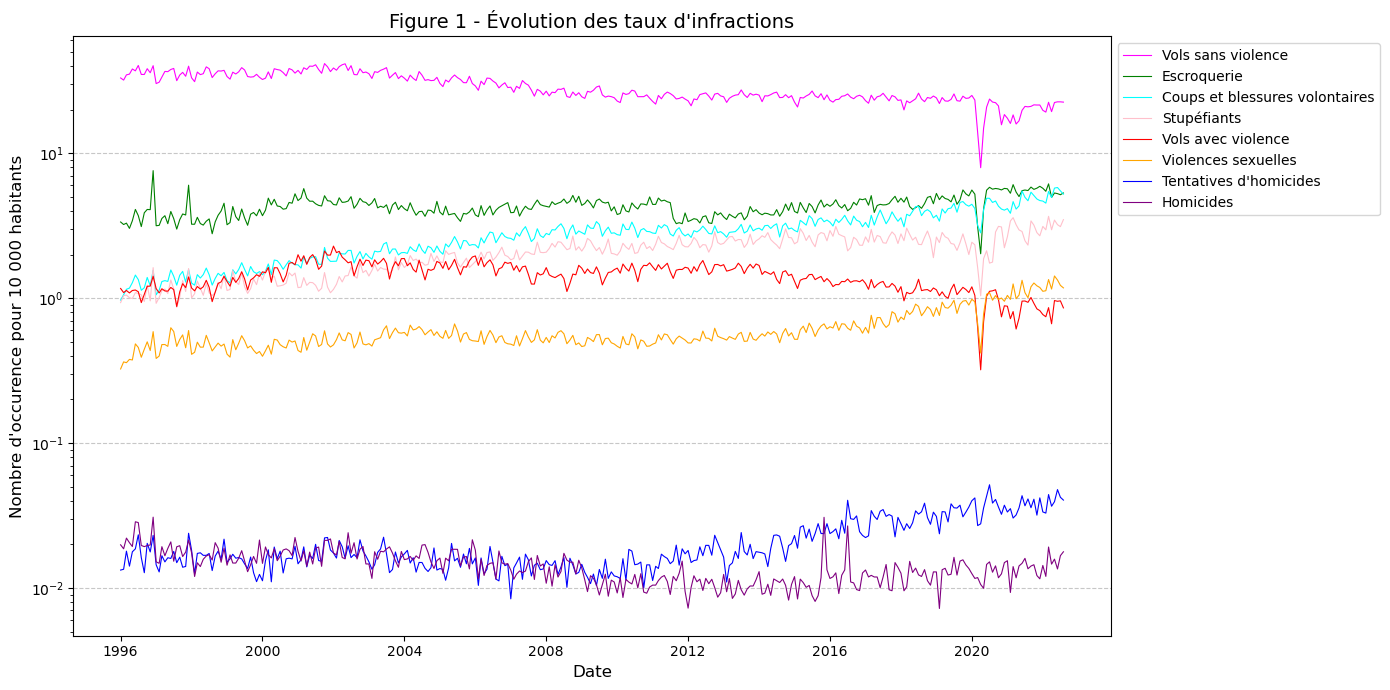

In [7]:
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux (/10 000)", use_log_scale = True, title="Figure 1 - Évolution des taux d'infractions")

Même si l'échelle logarithmique écrase un peu les évolutions de long terme, la Figure 1 permet d'illustrer les évolutions des nombres d'infractions pour 10 000 habitants pour chacun de nos indicateurs. On remarque d'ores et déjà des évolutions contrastées. Certains types d'infractions sont plutôt à la baisse (homicides, vols de tout types) quand d'autres augmentent (tentatives d'homicides, coups et blessures volontaires, escroqueries).

De manière générale, les taux d’infraction ne présentent pas de variations brutales au fil du temps : ils suivent une tendance relativement stable à part les homicides et les tentatives d'homicides qui repartent à la hausse depuis la dernières décennies (même si les homicides sont toujours moins fréquents en 2022 qu'en 1996).

En normalisant tous les taux à leur valeur en 1996, les Figures 2 et 3 permettent de visualiser l’évolution relative de chaque type d’infraction par rapport à cette année de référence. En particulier, la Figure 3 présente les courbes lissée des tendances grâce à l’application d’un filtre de Savitzky-Golay. Ce filtre est conçu pour lisser les séries temporelles en ajustant des polynômes locaux à travers une fenêtre glissante, ce qui permet d'éliminer le "bruit" statistique.

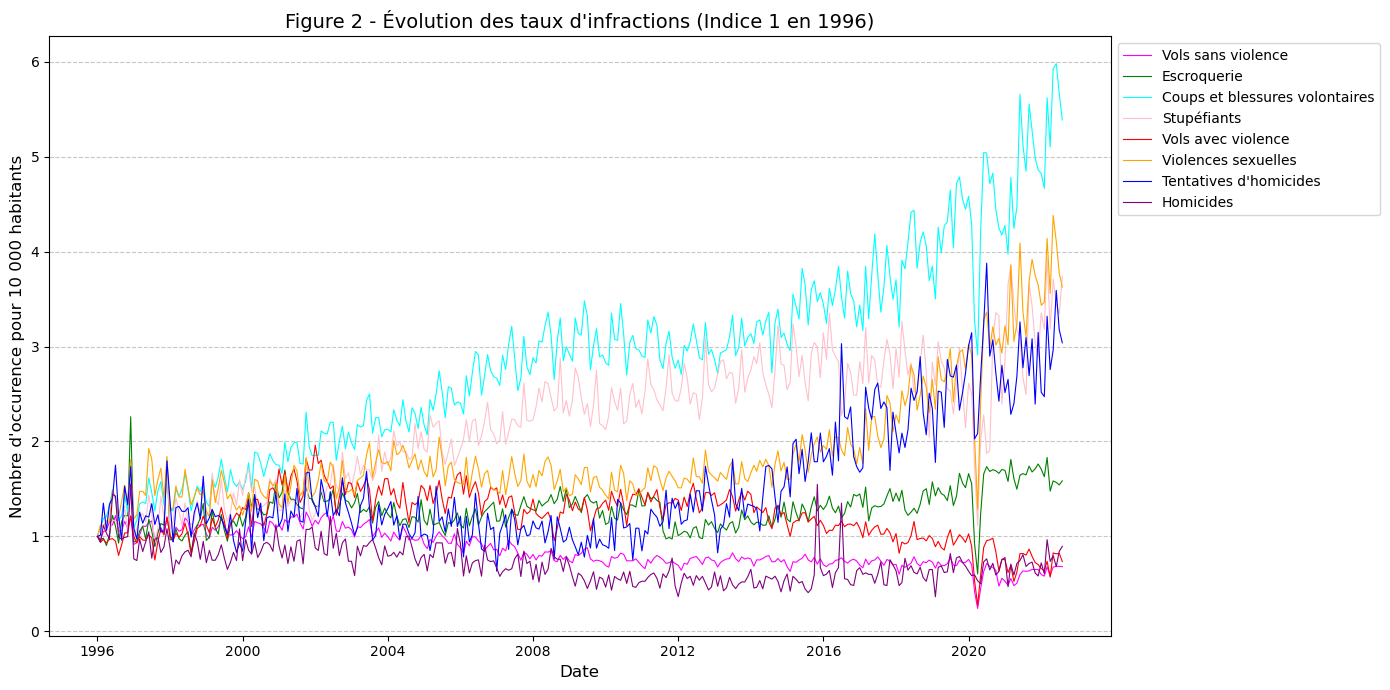

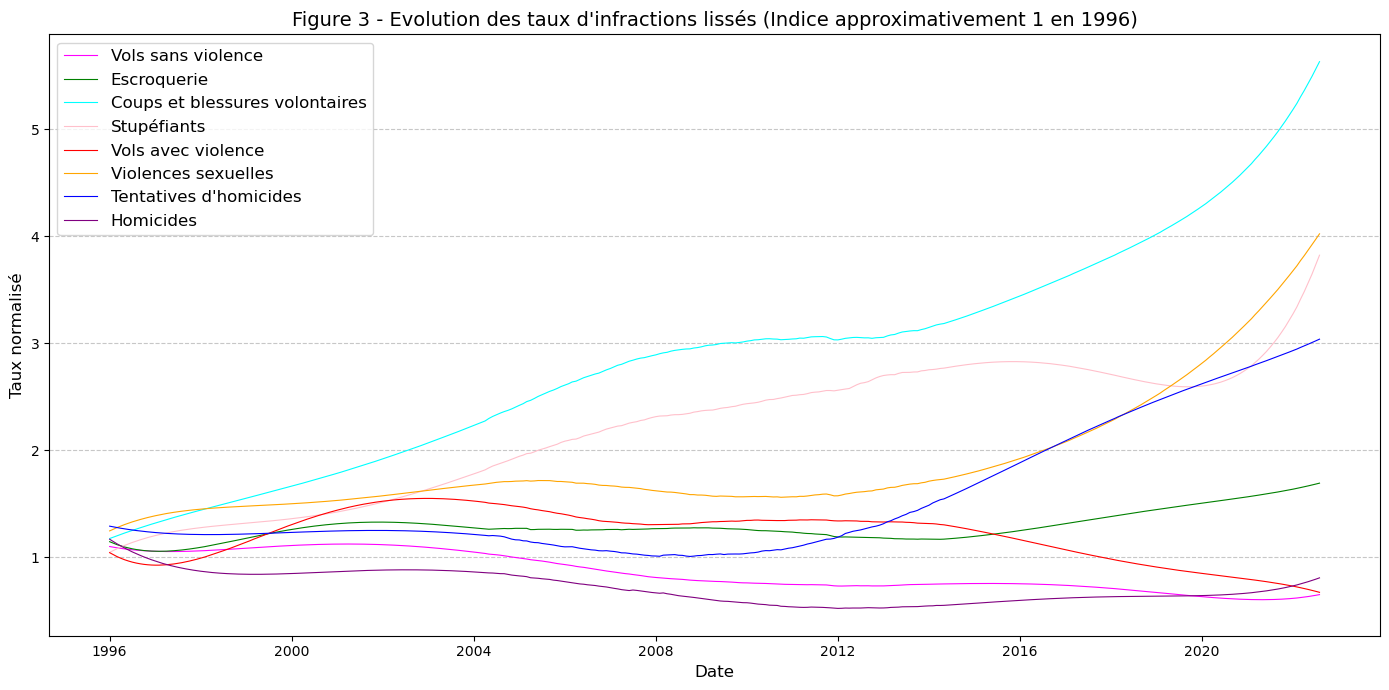

 Homicides entre 1996-01-01 et 2022-08-01: -10.47858905472778 %
 Tentatives d'homicides entre 1996-01-01 et 2022-08-01: 203.96935961992378 %
 Vols avec violence entre 1996-01-01 et 2022-08-01: -26.53294218387946 %
 Vols sans violence entre 1996-01-01 et 2022-08-01: -31.904976615785706 %
 Escroquerie entre 1996-01-01 et 2022-08-01: 58.49635036177963 %
 Coups et blessures volontaires entre 1996-01-01 et 2022-08-01: 438.69498681855345 %
 Violences sexuelles entre 1996-01-01 et 2022-08-01: 262.6825902105622 %
 Stupéfiants entre 1996-01-01 et 2022-08-01: 273.78697439863026 %


In [8]:
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif", title="Figure 2 - Évolution des taux d'infractions (Indice 1 en 1996)")
tracer_evolution_taux_relatif_lisse(df_indicateurs_nat, charte_graphique, title="Figure 3 - Evolution des taux d'infractions lissés (Indice approximativement 1 en 1996)")

liste = ['Homicides', "Tentatives d'homicides", 'Vols avec violence', 'Vols sans violence', 'Escroquerie', 'Coups et blessures volontaires', 'Violences sexuelles', 'Stupéfiants']
for indicateur in liste : 
    get_increase(df_indicateurs_nat, indicateur=indicateur, date1='1996-01-01', date2='2022-08-01')

In [9]:
get_increase(df_indicateurs_nat, indicateur='Violences sexuelles', date1='1996-01-01', date2='2007-01-01')
get_increase(df_indicateurs_nat, indicateur='Violences sexuelles', date1='2007-01-01', date2='2022-08-01')

 Violences sexuelles entre 1996-01-01 et 2007-01-01: 48.36255085018586 %
 Violences sexuelles entre 2007-01-01 et 2022-08-01: 144.45696581261487 %


A nouveau, on constate des tendances contrastées ce qui traduit une transformation des phénomènes délinquants. Les menages seraient moins souvent confrontés à des vols de tout types mais plus souvent à des escroqueries ce qui coincide avec les enquêtes de victimation. Plus généralement, les homicides et vols sont à la baisse alors que le reste des indicateurs augmentent (plus ou moins). On constate par exemple que les coups et blessures volontaires ont plus que quadruplées (augmentation de 438%). Les violences sexuelles augmentent elles-aussi significativement sur la période puisqu'elles font plus que doubler. Dans un contexte de libération de la parole et d’incitation à déposer plainte, notamment à travers l’amélioration (toute relative) des conditions d’accueil des victimes, les personnes déclarent plus fréquemment avoir subi des violences sexuelles et déposent plus souvent plainte. Cette augmentation ne concorde en revanche pas avec les résultats des enquêtes de victimation qui restent plutôt stable. Il est par ailleurs intéressant de constater que l'augmentation des violences sexuelles déclarées est beaucoup plus accrue dans la deuxième moitié de la période (qui correspond à la période d'existence du mouvement Me Too).

Enfin, la Figure 4, quant à elle, zoome sur une période spécifique : celle de la pandémie de COVID-19.

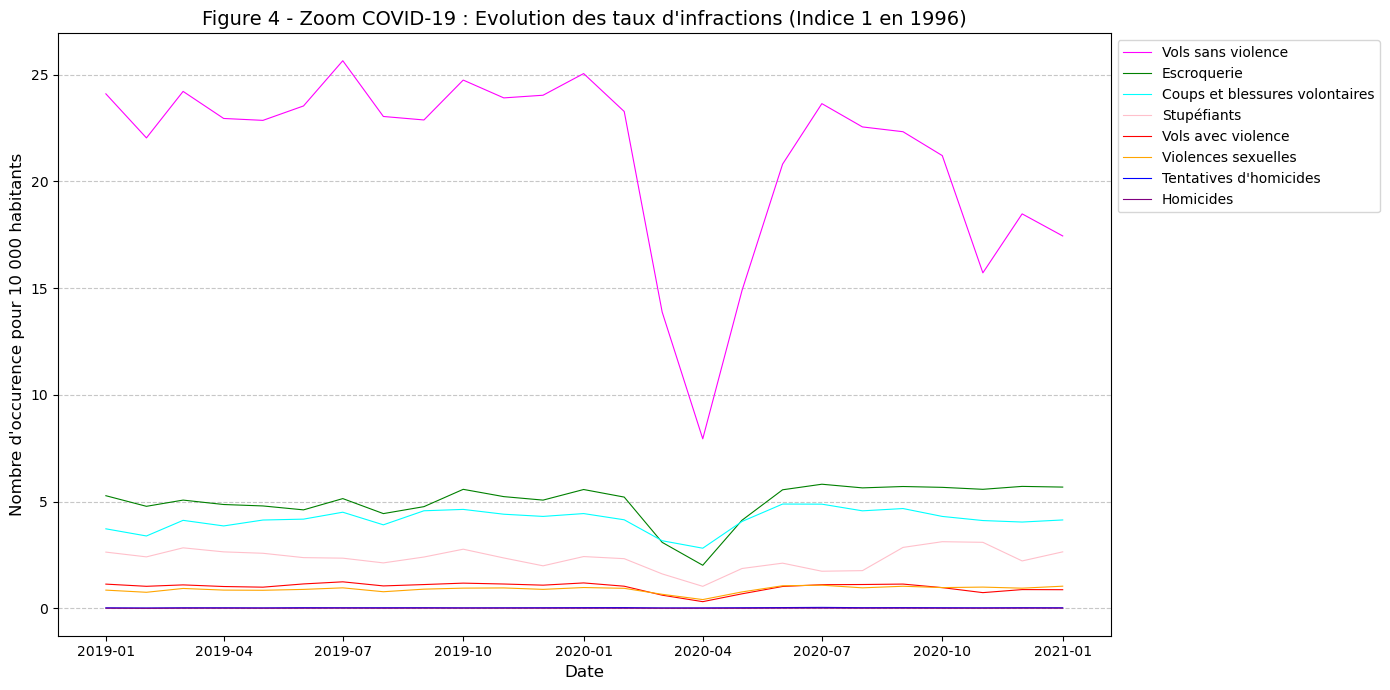

In [10]:
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, title="Figure 4 - Zoom COVID-19 : Evolution des taux d'infractions (Indice 1 en 1996)", use_log_scale=False, time_period=["2019-01-01", "2021-01-01"])

Cette période est marquée par une chute significative de presque tous les indicateurs, avec un creux particulièrement notable en avril 2020, correspondant aux mesures de confinement les plus strictes. Seuls les homicides semblent relativement épargnées par cette baisse, ce qui pourrait s'expliquer par la nature moins opportuniste de ce type de crime (donc moins influencé par les restrictions de mobilité). L'activité criminelle a ainsi été largement perturbée par les restrictions de déplacement, la fermeture des commerces, l'augmentation de la surveillance, etc.

D'autres tendance globale de l'activité criminelle se remarques dans nos données, notamment une certaine saisonnalité.

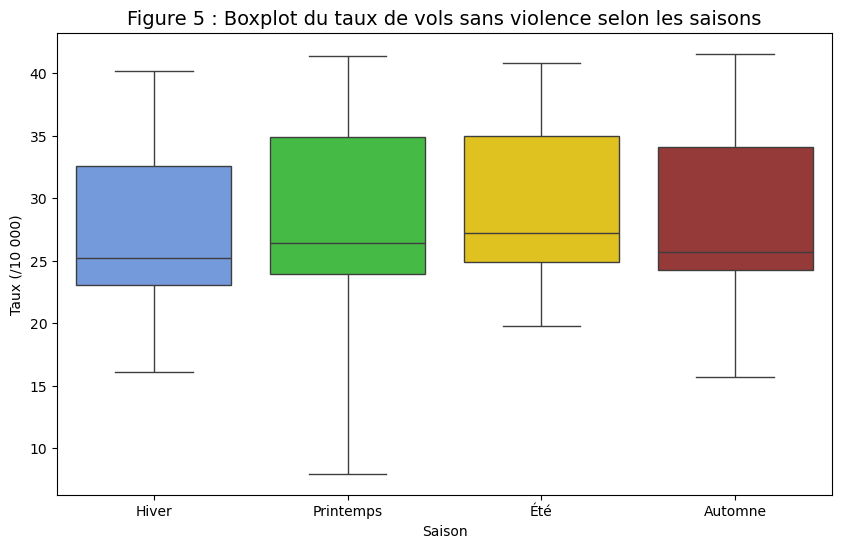

In [11]:
boxplot_indicateur_par_saison(df_indicateurs_nat, "Vols sans violence", title="Figure 5 : Boxplot du taux de vols sans violence selon les saisons")

La Figure 6 n'illustre que le cas des vols sans violences, mais en affichant les autres boxplot, une tendance générale à un taux d'infractions plus élevé en été apparaît pour tous les indicateurs.

#### Cartographie<a class="anchor" id="partie412"></a>

Pour finir, nous une représentation plus visuelle de ces évolutions avec des cartes animées. Il est intéressant de constater que si, pour certains indicateurs certaines concentrations géographiques restent constantes autour du temps (autour de l'Ile de France et de la côté d'Azur souvent), ces phénomène de concentratons n'existent pas pour les homicides ou les violences sexuelles qui semblent beaucoup plus uniformément répartis sur le territoire.

*NB3 : On s'est rendu compte que les animations ne s'affichaient pas dans le notebook sur GitHub, elles sont donc sauvegardées dans le dossier ***animations*** pour être visualisée au besoin.*

In [ ]:
for indicateur in liste :
    evolution_indicateur_animation(df_indicateurs_dep, indicateur)   

En parallèle de ces évolutions assez substantielles de nos indicateurs de criminalité, on a cherché à observer si la densité évoluait particulièrement sur la période. En pratique l'échelle du département est probablement trop large pour rendre compte de ces évolutions (les campagnes "noient" les évolutions qui sont surtout urbaines). Concrètement, la carte animée est plutôt très statique. Plus généralement, en consultant la littérature associée, il semble que l'inclusion de critère géographique dans l'étude de la criminalité pose souvent ce type de problème puisque l'échelle départementale est souvent inadaptée à l'échelle à laquelle ont étudie souvent les organisations spatiales.

In [ ]:
animer_evolution_densite(df=df_indicateurs_dep, colonne_densite='Densité')

Si on est très attentif, on voit que l'essentiel des variations se fait au niveau de l'Ile de France, on a donc proposé un zoom au niveau de cette zone géographique, qui résume en pratique quasi la totalité des variations de densité visible à cette échelle.

In [ ]:
evolution_idf_animation(df_indicateurs_dep, 'Densité')

### La législation sécuritaire en France<a class="anchor" id="partie42"></a>

#### Statistiques descriptives<a class="anchor" id="partie421"></a>

On cherche, pour cette base de données, à observer les différents types de textes promulgués et leur part respective. Cette analyse est présentée d'abord pour l'ensemble des années (Figure 6), puis décomposée au fil du temps (figures suivantes), permettant ainsi de suivre l'évolution des publications.

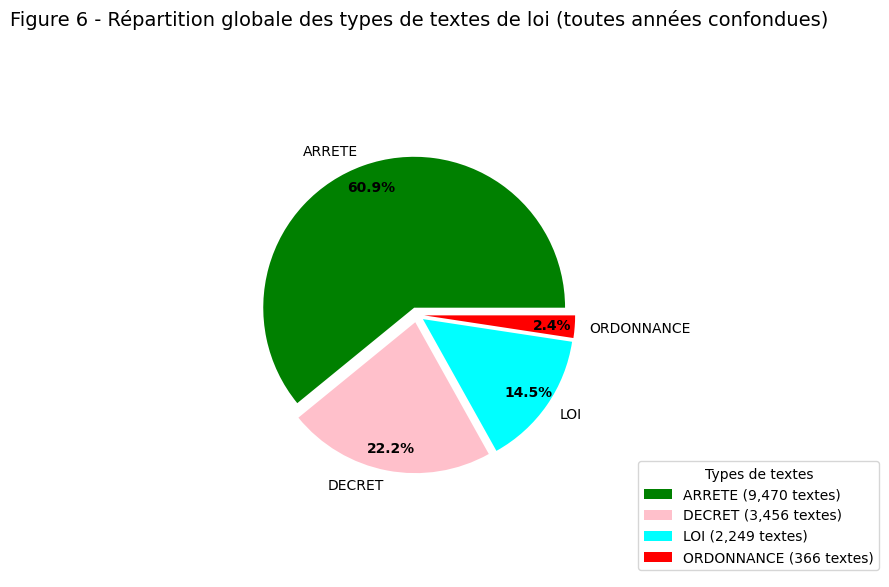

In [12]:
camembert(df_loda)

La base de données obtenue via l'API est à l'état brute, c'est-à-dire que chaque ligne correspond à une observation : chaque ligne représente, en effet, un texte individuel avec les informations sur sa publication.

Afin de produire une visualisation temporelle de ces données, nous avons réorganiser ces données pour obtenir un tableau agrégé qui montre, pour chaque mois, chaque année et chaque type de texte, le nombre de ce type texte de loi promulgués en fonction de sa nature (loi, décret, arrêté, ordonnance). C'est le rôle de la fonction tri_occurrence, en agrégeant les observations par mois et par nature. 

La ligne de code ci-dessous permet de mieux comprendre l'idée générale du tableau obtenu grâce à la fonction tri_occurrence appliquée au dataframe df_loda initial.

In [13]:
tri_occurrence(df_loda).head(10)

,year,month,day,Date,Indicateur,Nombre,Cumulatif
0,1996,1,1,1996-01-01,Texte,1.0,1.0
1,1996,1,1,1996-01-01,Arrete,1.0,1.0
2,1996,1,1,1996-01-01,Ordonnance,0.0,0.0
3,1996,1,1,1996-01-01,Loi,0.0,0.0
4,1996,1,1,1996-01-01,Decret,0.0,0.0
5,1996,2,1,1996-02-01,Ordonnance,0.0,0.0
6,1996,2,1,1996-02-01,Arrete,3.0,4.0
7,1996,2,1,1996-02-01,Loi,1.0,1.0
8,1996,2,1,1996-02-01,Texte,9.0,10.0
9,1996,2,1,1996-02-01,Decret,5.0,5.0


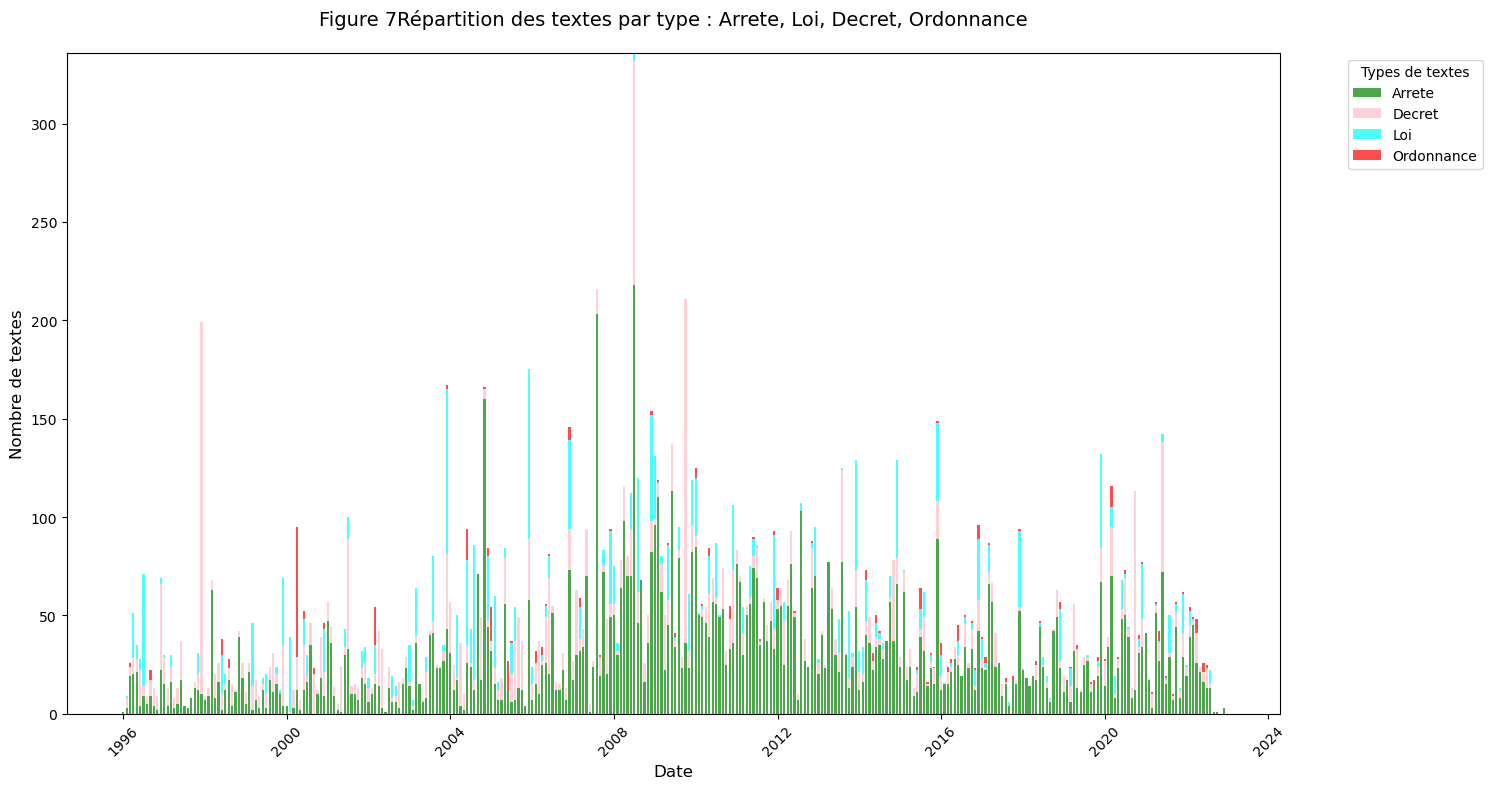

In [17]:
all = ["Arrete", "Loi", "Decret", "Ordonnance"]

plot_histogram(tri_occurrence(df_loda), all, numero_figure ='Figure 7')

Ce diagramme en barre montre le nombre de textes législatifs publiés de 1996 à 2022. Globalement, on observe une tendance progressive à la hausse de 1996 à 2009 du nombre de publications au cours du temps, jusqu'à atteindre un pic de plus de 300 textes en 2009, puis une légère tendance à la baisse jusqu'en 2020. Les arrêtés (barres vertes) sont la première catégorie la plus fréquente et constituent la majeure partie de l'activité législative, en particulier à partir de 2006. Les lois (bleu clair), décrets (rose pâle) et ordonnances (rouge) sont moins nombreux, mais réguliers et leur volume reste significatif pour l'analyse. Les ordonnances (rouge) sont bien plus rares pendant toute la période étudiée.

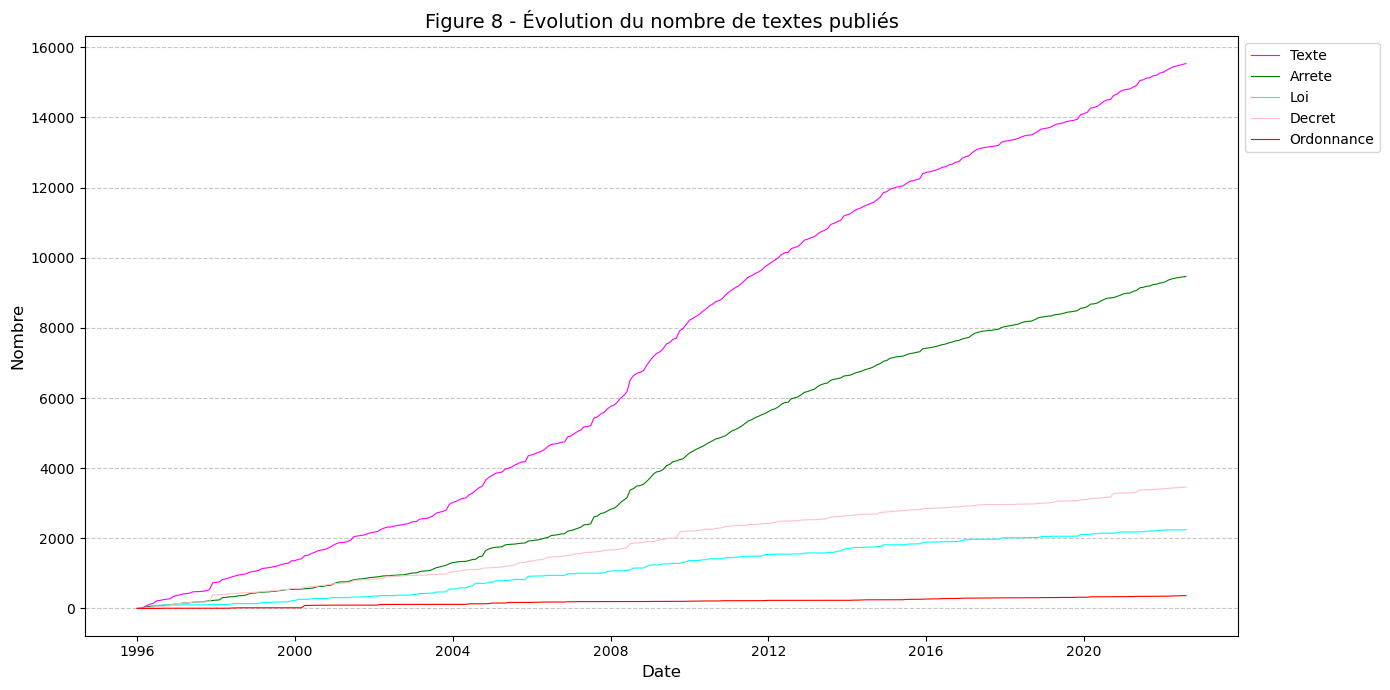

In [18]:
tracer_evolution_taux(tri_occurrence(df_loda), charte_graphique3, taux = "Cumulatif", title="Figure 8 - Évolution du nombre de textes publiés", xlabel = "Date",ylabel = "Nombre", time_period = ["1996-01-01", "2022-08-31"])

Cette figure présente l’évolution cumulée des textes publiés au fil du temps et donc permet de visualiser plus clairement la croissance globale de la production législative depuis 1996. La courbe rose (Texte) illustre bien la tendance précédemment mentionnée plutôt décroissante depuis 2009 avec une courbe d'abord linéaire voire concave et convexe ensuite. Elle atteint plus de 15 000 textes en 2022 dont les arrêtés (vert) constituent presque 10 000 publications. Les lois, décrets et ordonnances s’accumulent plus lentement, avec une progression presque linéaire.

<span style="color:red;">**les 2 prochaiens cases de codes viennet d'un quiproquo, a voir si ca peut servir pour filtrer tout de même**</span>

'''
Nous allons maintenant concentrer notre analyse sur l'activité législative en lien avec les crimes et les infractions, en écartant les textes qui ne relèvent pas de ces thématiques. L'objectif est de cibler les mesures et décisions ayant un impact sur la justice. Pour ce faire, nous allons rechercher des mots-clés appartenant à ce champ lexical dans les titres des publications, afin de les croiser ultérieurement avec nos données de criminalité.
'''

In [ ]:
'''
mots_delit_frequents = count_crime_keywords(df_loda)
mots_delit_frequents = mots_delit_frequents[mots_delit_frequents['Fréquence']>0]
mots_delit_frequents
'''

'''Les mots revenants le plus souvent sont ceux dont la fréquence (seuil choisit arbitrairement), est au dessus de 10.'''

In [ ]:
# plot_histogram(tri_occurrence(filter_rows_with_keyword(df_loda, 'vol')), all)

## Modélisation<a class="anchor" id="partie5"></a>

Dans nos deux parties de statistiques descriptives, on a dégagé des saisonnalité annuelle. Pour la modélisation économétrique, on décide d'indicer temporellement nos données par les années pour éviter que ces problèmes de saisonnalité impacte trop l'indépendance des différentes observations utilisées.

<span style="color:red;">**besoin de la base législative propre et en gros sa forme définitive pour faire quelque chose**</span>

### Fusion des bases de données<a class="anchor" id="partie51"></a>

### Régression(s ?)<a class="anchor" id="partie51"></a>

<span style="color:red;">**la faire, here des indicatiosn tirées de chat et de vergara-merino**</span>


Explication de en gros ce que j'ai compris de chatgpt et vergara-merino

On peut faire une regréssion de panel de la forme : <br>
$$
Y_{it} = \alpha + \beta \cdot L_t + \gamma \cdot G_{it}+ \mu _i + \epsilon _{it}
$$

où : <br>
$Y_{it}$ : Taux de criminalité (pour notre indicateur préféré qu'on choisirat j'imagine) di département i à l'année t<br>
$L_t$ : Mesure de l'intensité législative, comme on a pas les arrêtés préfectoraux sur légifrance on est obligé d'en faire une variable constante pour tous les départements i, elle est donc seulement indicée par t (les différences entre departement viennent donc des variables de contrôles à priori)<br>
$G_{it}$ : Variable de contrôle : pour la table départementale c'est la densité (en vrai l'échelle départementale est pas hyper appropriée pour l'utiliser comme contrôlé mais bon)<br>
$\mu _i$ : effet fixe aux départements (pour différences structurelles non observées)<br>
$\epsilon _{it}$ : error term<br>


Regression simple aussi : <br>
$$
Y_t = \alpha + \beta \cdot L_t + \gamma \cdot G_t + \epsilon _t
$$

où : <br>
$Y_t$ : Taux de criminalité (pour notre indicateur préféré qu'on choisirat j'imagine)  à l'année t<br>
$L_t$ : Mesure de l'intensité législative<br>
$G_t$ : Variable de contrôle : pour la table nationale, le taux de pauvreté<br>
$\epsilon _t$ : error term<br>


Complément chatgpt sur les deux trucs, pas exécuter ces lignes de code, lui demander pour further details

In [ ]:
 Mise en Place du Code pour regression de panel:
Bibliothèque Python : Utilise statsmodels ou linearmodels pour estimer les régressions de panel.
Exemple de Code :

from linearmodels.panel import PanelOLS
import pandas as pd

# Chargement des données en format panel
data = pd.read_csv("data_panel.csv")  # Assure-toi que le dataset est au format long
data = data.set_index(['department', 'year'])

# Modèle à Effets Fixes
model = PanelOLS.from_formula('Y ~ L + G + EntityEffects', data=data)
results = model.fit()
print(results.summary)


In [ ]:
Suggestions :
Inclure des retards législatifs : Les lois peuvent ne pas avoir d'effet immédiat. Tu pourrais tester des versions retardées de 
𝐿𝑡 (par exemple, 𝐿𝑡−1,𝐿𝑡−2)

Validation des hypothèses : Vérifie que les résidus ne sont pas autocorrélés (test de Durbin-Watson, etc.).

3. Mise en Place du Code :
Bibliothèque Python : statsmodels pour les régressions simples.
Exemple de Code :
python
Copier le code
import statsmodels.api as sm

# Préparer les variables
X = df[['L', 'G']]  # Variables explicatives
X = sm.add_constant(X)  # Ajoute une constante pour l'intercept
Y = df['Y']  # Variable dépendante

# Régression simple
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

## Conclusion et perspectives<a class="anchor" id="partie6"></a>